In [37]:
import os
import pandas as pd

df_list = []
for filename in os.listdir("/home/frankwoods/Desktop/LASSIE/data/raw_data"):
    # creates dataframe holding entire csv
    df = pd.read_csv(f"/home/frankwoods/Desktop/LASSIE/data/raw_data/{filename}")
    # takes just the two important columns
    df = df[['toeforce_y', 'toe_position_y']]
    df.columns = ["resistance", "depth"] # rename columns
    df_list.append(df)
print(f"example: {df_list[0]}")

example:        resistance     depth
0       -0.683593 -0.188659
1       -0.683593 -0.188659
2       -0.683593 -0.188659
3       -0.683593 -0.188659
4       -0.683593 -0.188659
...           ...       ...
11599   -1.929471 -0.158198
11600   -1.929471 -0.158198
11601   -1.929471 -0.158198
11602   -1.929471 -0.158198
11603   -1.929471 -0.158198

[11604 rows x 2 columns]


## Initial data visualization and summary

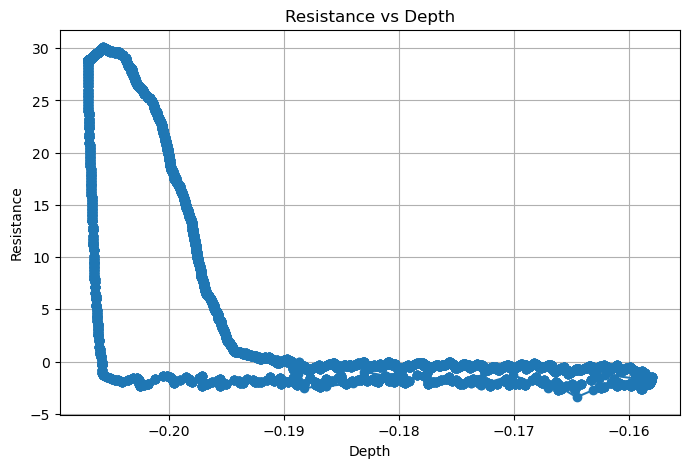

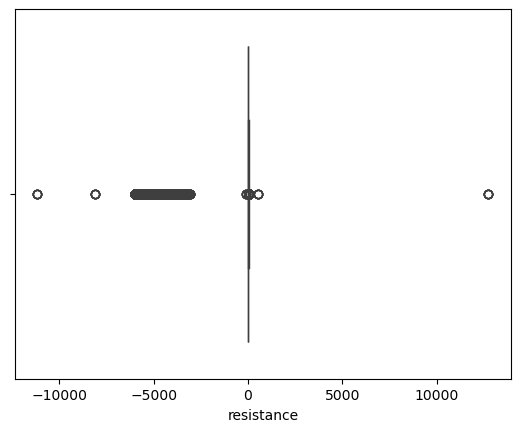

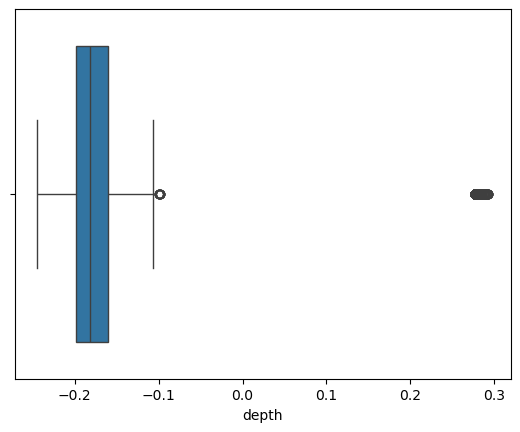

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---- plot an example graph ----
# Assume you have a DataFrame df with columns 'depth' and 'resistance'
def visualize_data(df_list, graph=False, box_plots=False, histograms=False, graph_i=0):
    if graph:
        plt.figure(figsize=(8,5))         # Optional: set figure size
        plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
        plt.xlabel('Depth')
        plt.ylabel('Resistance')
        plt.title('Resistance vs Depth')
        plt.grid(True)                    
        plt.show()

    df_combined_row_wise = pd.concat(df_list, axis=0)
    if box_plots:
        # ---- resistance ----
        sns.boxplot(x=df_combined_row_wise['resistance'])
        plt.show()
        resistance_series = df_combined_row_wise['resistance']
        # ---- depth ----
        sns.boxplot(x=df_combined_row_wise['depth'])
        plt.show()
    if histograms:
        plt.hist(df_combined_row_wise["resistance"], bins=30, density=True)
        plt.title("Resistance Histogram")
        plt.show()

        plt.hist(df_combined_row_wise["depth"], bins=30, density=True)
        plt.title("Depth Histogram")
        plt.show()


visualize_data(df_list, True, True, False)

## Inverse Depth, Remove Data of Before Leg Hits Ground, Remove Data of After Leg Hits Ground

In [39]:
# default normalization is non-robust to outliers
from sklearn import preprocessing
from tqdm import tqdm
import numpy as np

res_count = 0
depth_count = 0
res_total = 0
depth_total = 0
for i in range(len(df_list)):
    res_condition = df_list[i]["resistance"] > 0
    depth_condition = df_list[i]["depth"] > 0
    res_count += res_condition.sum()
    depth_count += depth_condition.sum()
    res_total += df_list[i]["resistance"].size
    depth_total += df_list[i]["depth"].size
# print(f"resistance count > 0: {res_count} / {res_total}")
# print(f"depth count > 0: {depth_count} / {depth_total}")

# negate depth bc all init depth values are negative
def clean_depth(df_i):
    df_i["depth"] = -df_i["depth"]
    # all depth values must be above 0, noise otherwise
    df_i = df_i[df_i["depth"] > 0]
    return df_i

# get the data starting from leg hitting ground, to the max depth
def clean_resistance(df_i):
    end_idx = df_i[df_i["depth"] == df_i["depth"].max()].index[0]
    start_idx = 0
    for i in range(end_idx + 1):
        if df_i["resistance"][i] < 0 and start_idx != end_idx:
            start_idx = i + 1
    return df_i.iloc[start_idx : end_idx + 1]

df_list = df_list[:65] + df_list[67:] # removing bad data entry
for i in range(len(df_list)):
    df_i = df_list[i]
    df_i = clean_depth(df_i)
    df_i = clean_resistance(df_i)
    # start every graph at 0
    df_i["depth"] = df_i["depth"] - df_i["depth"].iloc[0]
    df_list[i] = df_i

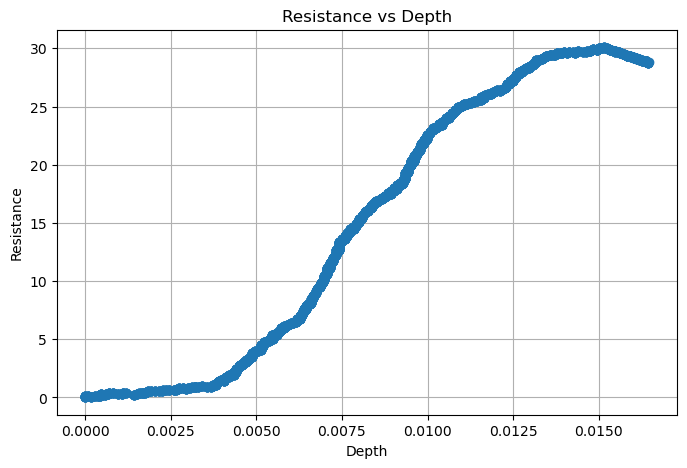

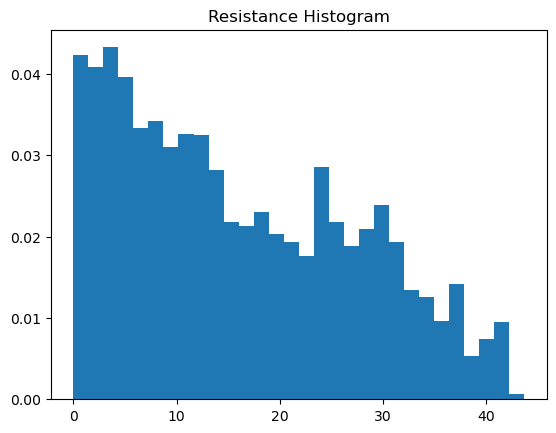

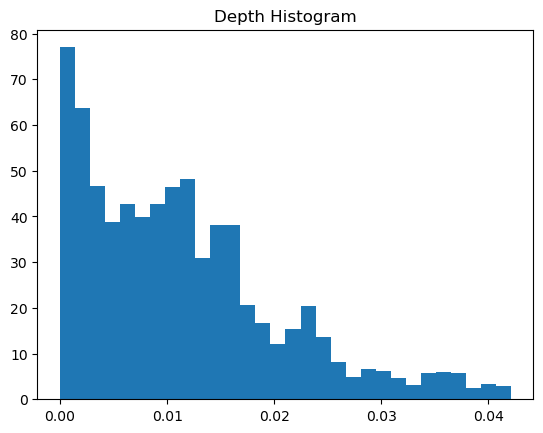

In [40]:
visualize_data(df_list, True, False, True)

# Make range of depth uniform
- truncate the data
    1. cut every dataframe to global depth end min
    2. cut every dataframe to some depth end
- pad the data
    1. linear regression extend a line to max global depth
    2. fit a polynomial function

0.0016654878854751032


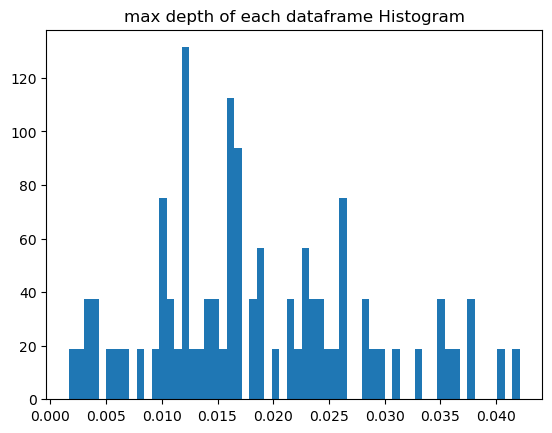

In [41]:

# depth_global_max = find_global_min_max(df_list)
min_of_all_df_depths = float('inf')
df_ends_list = []
for df in df_list:
    df_max_depth = df["depth"].max()
    if min_of_all_df_depths > df_max_depth:
        min_of_all_df_depths = df_max_depth
    df_ends_list.append(df_max_depth)
print(min_of_all_df_depths)

plt.hist(df_ends_list, bins=60, density=True)
plt.title("max depth of each dataframe Histogram")
plt.show()


# Truncating

Truncating at 0.08 to catch most of the distribution data but at the expense of cutting data sequences with and end below 0.08

After truncation 9 data objects were removed due to set trunc_level


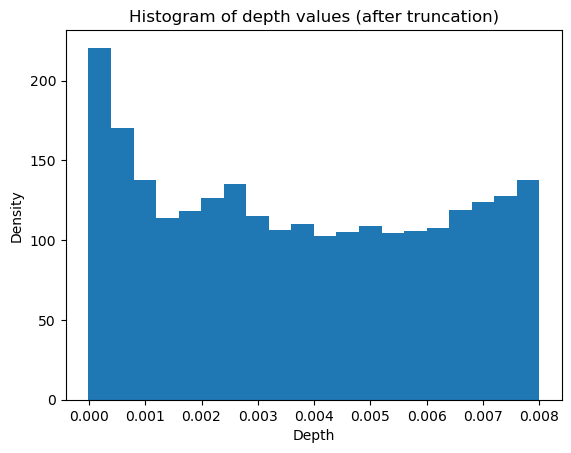

In [42]:
def truncate_df_list(df_list, trunc_level: float):
    truncated_list = []
    count = 0
    for df in df_list:
        max_depth = df["depth"].max()
        if max_depth >= trunc_level:
            truncated_df = df[df["depth"] <= trunc_level].copy()
            truncated_list.append(truncated_df)
        else:
            count += 1
    print(f"After truncation {count} data objects were removed due to set trunc_level")
    return truncated_list

trunc_df_list = truncate_df_list(df_list, trunc_level=0.008)
df_combined_row_wise = pd.concat(trunc_df_list, axis=0)

# Optional: visualize combined depths
# this histogram is showing all depths, not just the end
plt.hist(df_combined_row_wise["depth"], bins=20, density=True)
plt.title("Histogram of depth values (after truncation)")
plt.xlabel("Depth")
plt.ylabel("Density")
plt.show()


# Interpolation
Used to estimate values between data points to create a uniform vector of data intervals for each data object.

Before interpolation


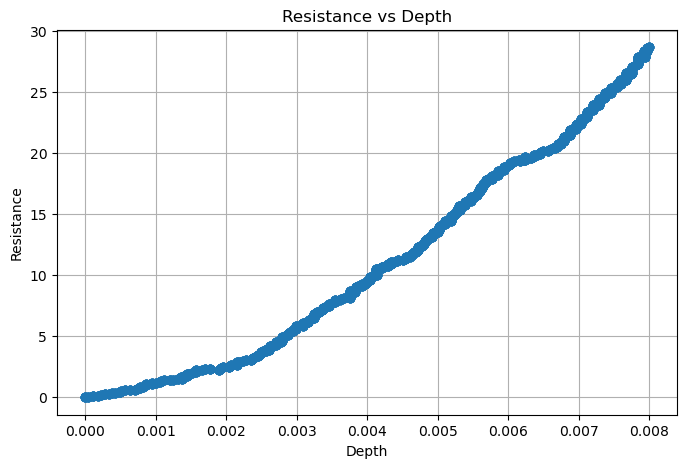

After interpolation


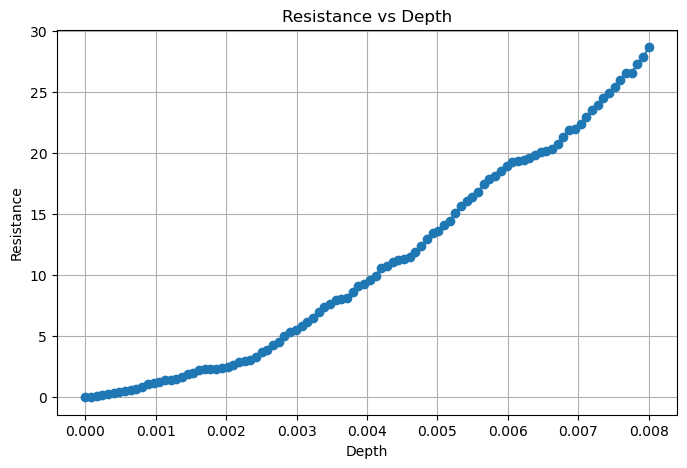

In [43]:

def interpolate(df_list, num_points):
    interp_df_list = []
    x_intervals = np.linspace(0, 0.008, num_points, endpoint=True) # 100 points between 0 and trunc_level
    for df in df_list:
        y_new = np.interp(x_intervals, df["depth"], df["resistance"])
        new_df = pd.DataFrame({'depth': x_intervals, 'resistance': y_new})
        interp_df_list.append(new_df)
    return interp_df_list

interpolated_df_list = interpolate(trunc_df_list, 100)
print("Before interpolation")
visualize_data(trunc_df_list, graph=True, graph_i=16)
print("After interpolation")
visualize_data(interpolated_df_list, graph=True, graph_i=16)



# Normalize the data

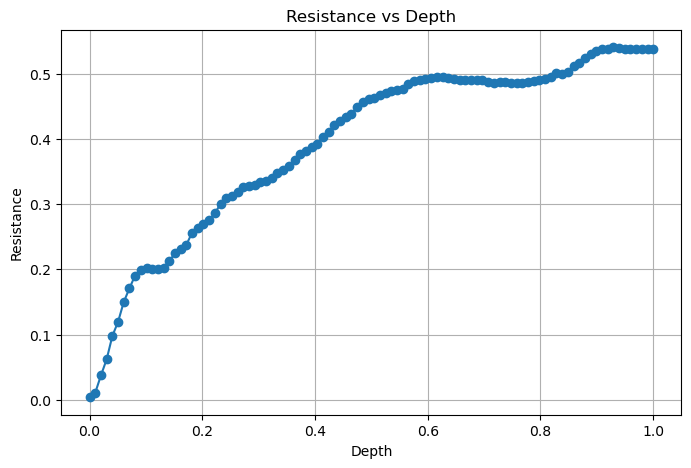

In [44]:
from sklearn.preprocessing import MinMaxScaler

def normalize(df_list):
    df_combined_row_wise = pd.concat(df_list, axis=0)
    scaler = MinMaxScaler()
    scaler.fit(df_combined_row_wise)
    normalized_df_list = []
    for df in df_list:
        normalized_df_list.append(pd.DataFrame(scaler.transform(df), columns=["depth", "resistance"]))
    return normalized_df_list

normalized_df_list = normalize(interpolated_df_list)
visualize_data(normalized_df_list, graph=True, graph_i=20)
    

# Final Visualization

In [45]:
# visualize_data(trunc_df_list, True, False, True)
def save_data_csv(final_df_list, save: bool):
    if save:
        for i in range(len(final_df_list)):
            final_df_list[i].to_csv(f"/home/frankwoods/Desktop/lassie/data/processed_data/resistance_depth_{i}.csv")

save_data_csv(normalized_df_list, True)